### Solving PDE (diffusion in insulated box)

We consider the diffusion problem

$$
    \begin{cases}
        \frac{\partial T}{\partial t} = k\Delta T \quad &\text{ in } \Omega, \quad 0<t<t_\text{end}, \\
        T = T_0 \quad &\text{ in } \Omega, \quad t = 0, \\
        \nabla T \bullet \hat{\mathbf{n}} = 0 \quad &\text{ on } \partial\Omega, \quad 0<t<t_\text{end}
    \end{cases}
$$

on the domain
$$
    \Omega := [-r_x,r_x] \times [-r_y,r_y] \times [-r_z,r_z] \subset \mathbb{R}^3.
$$
Here $\Delta$ is the Laplace operator
$$
    \Delta := \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2},
$$
$k>0$ is a given constant, $T_0$ is a given function
$$
    T_0 : \Omega \rightarrow \mathbb{R}
$$
and
$$
    \hat{\mathbf{n}}: \partial\Omega \rightarrow \mathbb{R}^3
$$
is the unit normal field to the domain boundary.

The approximating B-spline object is 
$$
    \tilde{T}: \Omega \times [0,t_\text{end}] \rightarrow \mathbb{R}.
$$

The PDE term of the loss function is
$$
    \text{Loss}_\text{PDE} = \frac{1}{n_xn_yn_zn_t}\sum_{i=0}^{n_x}\sum_{j=0}^{n_y}\sum_{k=0}^{n_z}\sum_{l=0}^{n_t} \left(\frac{\partial\tilde{T}}{\partial t}(x_i,y_j,z_k,t_l) - k\Delta\tilde{T}(x_i,y_j,z_k,t_l)\right)^2
$$

with 
$$
x_i = -r_x + 2r_x \frac{i-1}{n_x-1},
$$
and analogously $y_j,z_k$, and
$$
    t_l = \frac{l-1}{n_l-1}t_\text{end}.
$$

In [1]:
import torch
import torch.nn as nn
import NURBS_PyTorch_2 as NP2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

class Diffusion_box(NP2.NURBS_object):
    
    def __init__(self,
                 k     = 2.,
                 r_x   = 1.,
                 r_y   = 1.,
                 r_z   = 1.,
                 t_end = 10., 
                 n_cpts_x = 10,
                 n_cpts_y = 10,
                 n_cpts_z = 10,
                 n_cpts_t = 10,
                 degrees_space   = (2,2,2),
                 degree_time     = 2,
                 hidden_layer_widths = [100,100],
                 param_init_r    = 1e-4,
                 learning_rate   = 1e-4,
                 eval_grid_shape = (15,15,15,15),
                 T0              = lambda x,y,z: (x-1/4)**2 + \
                                                 (y-1/4)**2 + \
                                                 (z-1/4)**2,
                 *args,
                 **kwargs):
        
        control_net_shape = (n_cpts_x,
                             n_cpts_y,
                             n_cpts_z,
                             n_cpts_t)
        
        super().__init__(control_net_shape,
                         *args,
                         **kwargs,
                         n_inputs  = 4, # Here the NURBS object is interpreted as the approximation function itself,
                         n_outputs = 1) # in stead of as a parameterization of the solution in the ODE example.
        
        self._object_name = "diffusion_box"
        
        self.k  = k
        self.T0 = T0
        
        # Evaluate T0
        x = torch.linspace(-r_x,r_x,eval_grid_shape[0],device = self.device)
        y = torch.linspace(-r_y,r_y,eval_grid_shape[1],device = self.device)
        z = torch.linspace(-r_z,r_z,eval_grid_shape[2],device = self.device)
        
        x,y,z = torch.meshgrid(x,y,z, indexing = 'ij')
        
        self.T0_eval = T0(x,y,z)
        
        self.r_x   = r_x
        self.r_y   = r_y
        self.r_z   = r_z
        self.t_end = t_end
        
        self.eval_grid_shape = eval_grid_shape
        
        ##
        ### Basis functions
        ##
        basis_functions = []
        
        # Basis functions for the space dimensions
        for degree, n_cpts, r in zip(degrees_space, [n_cpts_x,
                                                     n_cpts_y,
                                                     n_cpts_z],
                                     [r_x,r_y,r_z]):
            
            
        
            kv = NP2.Knot_vector.make_open(degree           = degree,
                                           n_control_points = n_cpts,
                                           param_min        = -r,
                                           param_max        = r,
                                           device           = self.device)
            
            basis_functions.append(NP2.Basis_functions(kv))
            
        # Basis functions for time dimension
        kv_t = NP2.Knot_vector.make_open(degree = degree_time,
                                         n_control_points = n_cpts_t,
                                         param_min        = 0,
                                         param_max        = t_end,
                                         device           = self.device)
        
        basis_functions.append(NP2.Basis_functions(kv_t))
        
        self.set_parameters(basis_function_sets = basis_functions)
        
        ##
        ### Optimization
        ##
        
        width_output = torch.prod(torch.tensor(control_net_shape))
        
        layer_widths = [1] + hidden_layer_widths + [width_output]
        
        # Layers of MLP network
        layers = [nn.Linear(layer_widths[i],layer_widths[i+1], device = self.device) \
                  for i in range(len(layer_widths)-1)]
        
        
        # Inialise weights and biases close to 0
        for layer in layers:
            layer.weight.data[:] = (2*torch.rand(layer.weight.data.shape)-1)*param_init_r
            layer.bias.data[:]   = (2*torch.rand(layer.bias.data.shape)-1)  *param_init_r
        
        layers_with_activation = sum([[layer,nn.Tanh()] for layer in layers], [])[:-1]
        
        self.network   = nn.Sequential(*layers_with_activation)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = learning_rate)
        
        self.n_iters_done = 0
        
        self.update_sol()
        
        
        self.eval_grid(n = eval_grid_shape,
                       construct_output  = False,
                       to_memory         = "for_training",
                       derivative_orders = (2,2,2,1))
        
        self.losses = []
        
        # Loss plotting
        fig, ax = plt.subplots(dpi = 100)
        ax.set_title("Loss")
        ax.set_yscale('log')
        
        self.fig         = fig
        self.ax          = ax
        self.error_curve = ax.plot([],[])[0]
        
        
    def update_fig(self):
        
        self.error_curve.set_data(range(self.n_iters_done),
                                  self.losses)
        
        self.ax.set_xlim(0,self.n_iters_done-1)
        self.ax.set_ylim(min(self.losses),
                         max(self.losses))
        
        self.fig.canvas.draw()
        
    def update_sol(self):
        self.set_parameters(control_point_coord_sets = 
                            [self.network(torch.ones(1,device = self.device)).reshape(self.control_net_shape)])
        
    def loss(self):
        
        T_t  = self.eval_grid(n = self.eval_grid_shape, from_memory = "for_training",
                              derivative_orders = (0,0,0,1)).squeeze()[:,:,:,:,1]
        
        T_xderivs = self.eval_grid(n = self.eval_grid_shape, from_memory = "for_training",
                                   derivative_orders = (2,0,0,0)).squeeze()
        T_yderivs = self.eval_grid(n = self.eval_grid_shape, from_memory = "for_training",
                                   derivative_orders = (0,2,0,0)).squeeze()
        T_zderivs = self.eval_grid(n = self.eval_grid_shape, from_memory = "for_training",
                                   derivative_orders = (0,0,2,0)).squeeze()
        
        T_xx = T_xderivs[:,:,:,:,2]
        T_yy = T_yderivs[:,:,:,:,2]
        T_zz = T_zderivs[:,:,:,:,2]
        
        
        
        loss_PDE = (T_t - self.k*(T_xx + T_yy + T_zz)).square().mean()
        loss_IC  = (T_xderivs[:,:,:,0,0] - self.T0_eval).square().mean()
        loss_BC  = T_xderivs[0,:,:,:,1].square().mean() + T_xderivs[-1,:,:,:,1].square().mean() + \
                   T_yderivs[:,0,:,:,1].square().mean() + T_yderivs[:,-1,:,:,1].square().mean() + \
                   T_zderivs[:,:,0,:,1].square().mean() + T_zderivs[:,:,-1,:,1].square().mean()
        
        return loss_PDE + loss_IC + loss_BC
    
    
    def iterate(self):
        
        self.optimizer.zero_grad()
        self.update_sol()
        loss = self.loss()
        loss.backward()
        self.optimizer.step()
        
        self.n_iters_done += 1
        self.losses.append(loss.item())
        
        
    def train(self,
          eps             = 1e-2,
          maxiter         = 2500,
          update_interval = 5):

        for i in tqdm(range(maxiter)):
            self.iterate()

            if self.n_iters_done % update_interval == 0:
                self.update_fig()

            if self.losses[-1] < eps:
                print("Converged")
                break

<IPython.core.display.Javascript object>


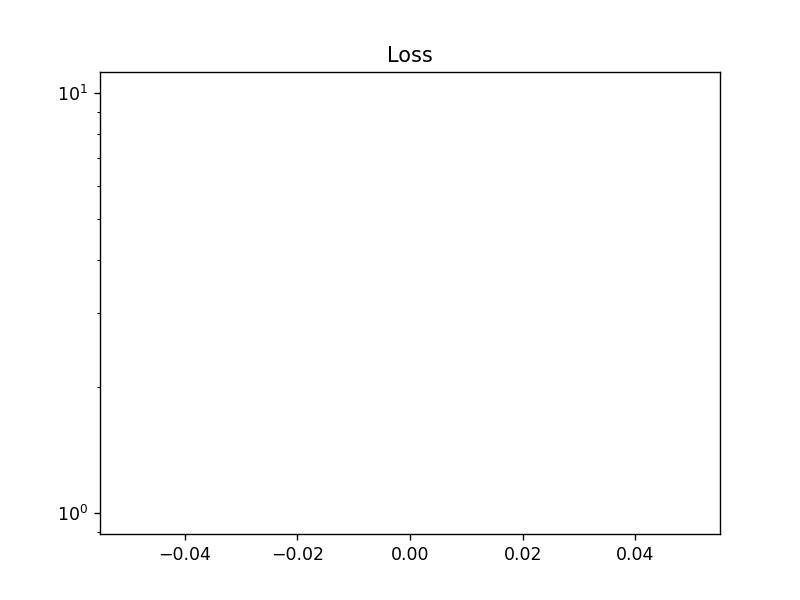

In [3]:
DB = Diffusion_box(hidden_layer_widths = [100,1000], learning_rate = 1e-5)

In [4]:
DB.train(maxiter = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 1.89 GiB (GPU 0; 4.00 GiB total capacity; 2.06 GiB already allocated; 0 bytes free; 2.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(DB)
print(DB.network)

In [ ]:
N = 25
x = torch.linspace(-DB.r_x,DB.r_x,N, device = DB.device)
y = torch.linspace(-DB.r_y,DB.r_y,N, device = DB.device)
z = torch.linspace(-DB.r_z,DB.r_z,N, device = DB.device)


# TODO: use eval_grid
x,y,z = torch.meshgrid(x,y,x, indexing = "ij")
x     = x.reshape(-1)
y     = y.reshape(-1)
z     = z.reshape(-1)
t     = torch.full_like(x, DB.t_end)

with torch.no_grad():
    Eval = DB(x,y,z,t).cpu()
    
# TODO: Add time slider, set heat colormap


fig = NP2.go.Figure(data=NP2.go.Volume(
    x=x.cpu(),
    y=y.cpu(),
    z=z.cpu(),
    value=Eval,
    #isomin=0.1,
    #isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=25, # needs to be a large number for good volume rendering
    ))
fig.show()